# Подготовка датасета для Spaceship Titanic

In [71]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bars(df, lst_features, lst_split = ['Transported'], ylim=(0,1)):
    """ Вывод значений для признаков из списка lst_features. Вычисление для них доли признкака lst_split """
    cols, i = len(lst_features)*len(lst_split), 1
    plt.figure(figsize=(cols*5, 4), facecolor ='w')     
    for f in lst_features: 
        for split in lst_split:         
            x = np.array( list(dict(df[f].value_counts()).items() ))            
            ax1 = plt.subplot(1, cols, i)
            plt.ylim(0, len(df)); plt.title(f); plt.yticks([]); # plt.xticks(x[:,0])
            plt.bar(x[:,0], x[:,1].astype(int))
            
            s = [  df.loc[df[f] == k, split].mean() for k, _ in x ]
            ax2 = ax1.twinx(); ax2.set_ylim(ylim)
            plt.plot(x[:,0], s, ":og", markersize=8)
            plt.axhline(y = (ylim[0]+ylim[1])/2, color = 'gray', linestyle = '-')
            plt.yticks(np.linspace(ylim[0],ylim[1],11)); plt.legend([split])
            plt.grid()
            i += 1
    plt.show()    
    
def plot_counts(df, lst_features, lst_split = ['Transported']):
    """ Аналогично plot_bars средствами seaborn """
    cols, i = len(lst_features)*len(lst_split), 1
    plt.figure(figsize=(cols*5, 4), facecolor ='w')     
    for f in lst_features: 
        for split in lst_split:         
            plt.subplot(1, cols, i)
            sns.countplot(x=f, hue=split, data=df).set(title=f)
            i += 1
    plt.show()    
    
#-------------------------------------------------------------------------------------------
        
def plot_float(df, lst_features, ymax):
    """ Вывод гистограмм веществественных признаков из списка lst_features """
    plt.figure(figsize=(20,8), facecolor ='w')       
    cnt = 1
    for col in lst_features: 
        if df[col].dtype == np.float64:                        
            x = df[col]
            plt.subplot(2, 6, cnt); 
            plt.hist(x, bins=30); plt.ylim(0, ymax)            
            plt.title(f"{col} [{x.min():.0f}, {x.max():.0f}]")
            cnt += 1
    plt.show()

## Пропуски данных

In [72]:
df_trn = pd.read_csv("dataset/train.csv")
df_tst = pd.read_csv("dataset/test.csv")   

display(df_trn.info())

print(f"df_trn: {df_trn.shape}\ndf_tst: {df_tst.shape}")

display( df_trn.isna().sum() )

print(f"Duplicate trn rows: {df_trn.duplicated().sum()}")
print(f"Duplicate tst rows: {df_tst.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


None

df_trn: (8693, 14)
df_tst: (4277, 13)


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Duplicate trn rows: 0
Duplicate tst rows: 0


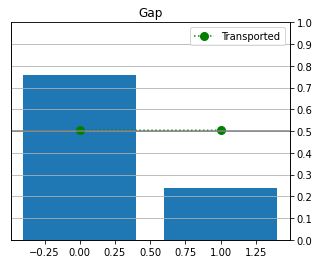

In [21]:
df_trn['Gap'] = df_trn.isna().any('columns')
plot_bars  (df_trn, ['Gap'])

✅ Во всех колонках, кроме `PassengerId`, `Transported` есть пропуски примерно 200 (2%) на колонку (в tst по 100).<br>
✅ Дубликатов данных (строк) нет.<br>
✅ Тестовые данные половина от тренировочных

✍ Пока игнорируем все строки с пропусками и проанализировав данные, решим как заполнять пропуски

In [73]:
def remove_gaps(df):
    """ Удаляет строки содержащие хотя бы один пропуск """
    cnt  = sum( len(df[df[col].isna()]) for col in df.columns )
    gaps = df.isna().any('columns')
    print(f"Share of gaps: {len(df[gaps]):4d}  ({100*gaps.mean():.1f}%); independently by columns {cnt}")
    
    df = df[~df.isna().any('columns')] 
    return df.reset_index()   
    
df_trn = remove_gaps(df_trn)
df_tst = remove_gaps(df_tst)
df_all = pd.concat([df_trn, df_tst], axis=0)          # объединённые данные (часть Transported==NaN)

Share of gaps: 2087  (24.0%); independently by columns 2324
Share of gaps:  996  (23.3%); independently by columns 1117


✅ В среднем 24% строк и в trn, и в tst имеют пропуски<br>
✅ Большинство строк имеет по одному пропуску, но есть по по два (см. последнее число)

In [4]:
df_trn.head()

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
df_tst.head()

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


## Базовые фичи

✅ Разобьём `PassengerId`, `Cabin`, `Name` на части<br>
✅ Введём суммарные траты `Tot` и признак их отсутствия `Tot0`

In [78]:
def features(df):
        
    df['Pass_GR'] = df.PassengerId.map(lambda x: x.split('_')[0])  # GR_ID
    df['Pass_ID'] = df.PassengerId.map(lambda x: x.split('_')[-1])
    
    groups = df.Pass_GR.value_counts()                            # список номеров групп с числом людей в них
    df['Size_GR'] = df.Pass_GR.map(lambda x: groups[x])           # для каждого человека резмер его группы
    df['Single']  = df.Size_GR == 1                               # одинокий путешественник
    
    df['Deck']    = df.Cabin.map(lambda x: x.split('/')[0])       # буква палубы
    df['Number']  = df.Cabin.map(lambda x: x.split('/')[1]).astype(int) # номер на палубе
    df['Side']    = df.Cabin.map(lambda x: x.split('/')[2])       # S,P - сторона номера (>)

    df['Deck_BCD']   = df.Deck.map(lambda x: x in 'BCD' )         # группировка по палубам (пригодится)
    df['Deck_ABCDF'] = df.Deck.map(lambda x: x in 'ABCDF' )        
    df['Deck_DET']   = df.Deck.map(lambda x: x in 'DET' )    
    df['Deck_GNS']   = (df.Deck == 'G') & (df.Number >= 750) & (df.Number <= 1200) & (df.Side == 'S')

    df['Name1']   = df.Name.map(lambda x: x.split(' ')[0])        # разбиваем полное имя имя
    df['Name2']   = df.Name.map(lambda x: x.split(' ')[1])
    
    df['Tot']     = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck   
    df['Tot_Out'] = df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck   
    df['Tot0']    = df.Tot <= 0           
    df['Tot_RS']  = df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck < 100
    
    df['Age_0']     = df.Age <= 0                                 # группы по возрастту (см. ниже)
    df['Age_1_4']   = (df.Age >=  1) & (df.Age <=  4)
    df['Age_5_12']  = (df.Age >=  5) & (df.Age <= 12)
    df['Age_18_40'] = (df.Age >= 18) & (df.Age <= 40)    
        
    df.CryoSleep = df.CryoSleep.astype(bool)                      # из-за пропусков были object
    df.VIP       = df.VIP.astype(bool)
    df.Side      = df.Side == 'S'                                 # {S,P}
    
    
features(df_trn)
features(df_tst)

display(df_trn.head(2))
display(df_trn.describe(include=[bool]))
display(df_trn.describe(include=[object]))
display(df_trn.describe())
# df_trn.nunique()

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,...,Name1,Name2,Tot,Tot_Out,Tot0,Tot_RS,Age_0,Age_1_4,Age_5_12,Age_18_40
0,0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,...,Maham,Ofracculy,0.0,0.0,True,True,False,False,False,True
1,1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,...,Juanna,Vines,736.0,627.0,False,False,False,False,False,True


,CryoSleep,VIP,Transported,Single,Side,Deck_BCD,Deck_ABCDF,Deck_DET,Deck_GNS,Tot0,Tot_RS,Age_0,Age_1_4,Age_5_12,Age_18_40
count,6606,6606,6606,6606,6606,6606,6606,6606,6606,6606,6606,6606,6606,6606,6606
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,True,True,True,False,True,False,False,False,False,False,False,False,True
freq,4274,6444,3327,4021,3345,5017,3948,5547,6308,3870,3545,6466,6378,6346,4062


,PassengerId,HomePlanet,Cabin,Destination,Name,Pass_GR,Pass_ID,Deck,Name1,Name2
count,6606,6606,6606,6606,6606,6606,6606,6606,6606,6606
unique,6606,3,5305,3,6590,5015,8,8,2531,2112
top,0001_01,Earth,G/1476/S,TRAPPIST-1e,Gwendy Sykess,4256,01,F,Kaye,Casonston
freq,1,3566,7,4576,2,8,4734,2152,10,17


,index,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Size_GR,Number,Tot,Tot_Out
count,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000
mean,4372.817741,28.894036,222.991674,478.958523,178.356494,313.161520,303.780048,1.783227,599.177414,1497.248259,1274.256585
std,2508.595067,14.533429,644.987936,1678.592291,576.328407,1144.016291,1127.142166,1.284366,513.450585,2860.618493,2787.659634
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2212.250000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,166.000000,0.000000,0.000000
50%,4366.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,424.000000,739.000000,330.000000
75%,6548.750000,38.000000,49.000000,82.750000,30.000000,65.000000,52.000000,2.000000,994.000000,1513.750000,1001.000000
max,8692.000000,79.000000,9920.000000,29813.000000,12253.000000,22408.000000,20336.000000,8.000000,1894.000000,35987.000000,35862.000000


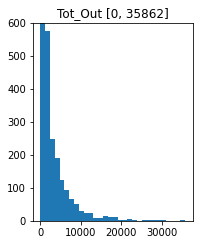

In [56]:
plot_float(df_trn, ['Tot_Out'], 600)

0.6042267050912584 1041


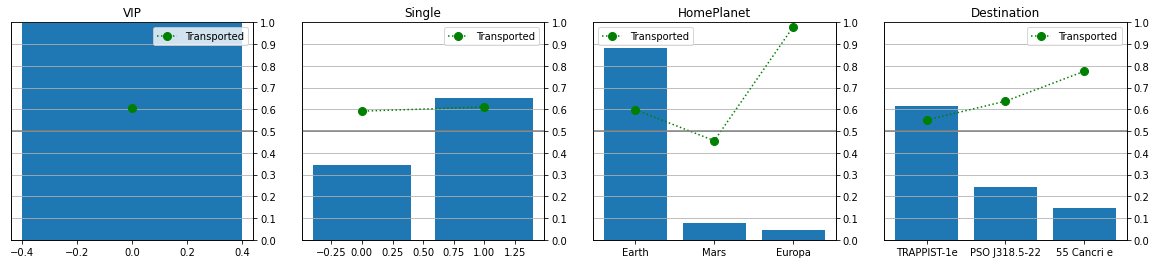

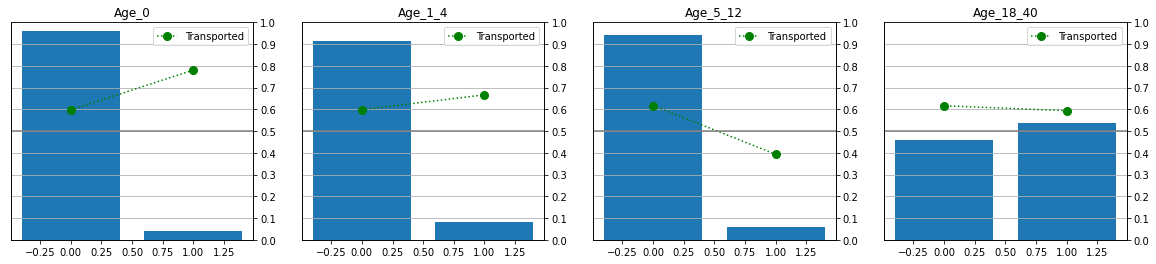

In [81]:
if True:
    df = df_trn[ (df_trn.CryoSleep) & ( df_trn.Deck_ABCDF | df_trn.Deck_GNS ) ]    # ( df_trn.Deck_ABCDF | df_trn.Deck_GNS ) 
    print(df.Transported.mean(), len(df))
    plot_bars  (df, ['VIP', 'Single','HomePlanet','Destination'])
    plot_bars  (df, ['Age_0', 'Age_1_4', 'Age_5_12', 'Age_18_40'])

## Логические признаки

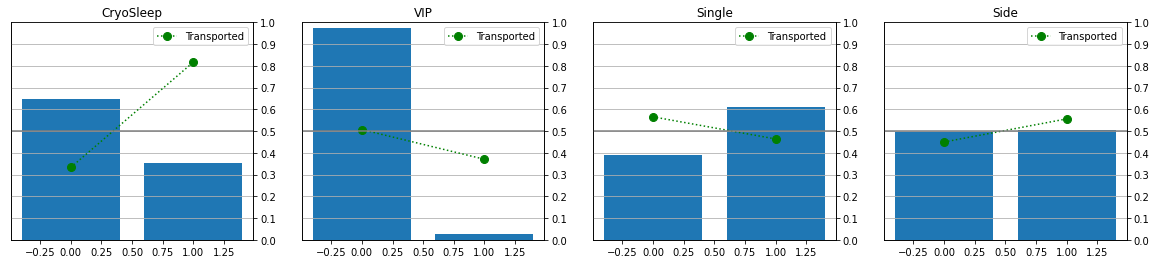

In [8]:
#plot_counts(df_trn, ['CryoSleep', 'VIP', 'Single', 'Side'])
plot_bars  (df_trn, ['CryoSleep', 'VIP', 'Single', 'Side'])

## CryoSleep	

✅ `CryoSleep` и `Tot0`- важные классификационные параметры `CryoSleep`=0.82/0.33<br>
✅ Все кто был в гибернации денег не платили; 9% не спящих тоже не платили<br>
✅  Любым методом acc = **0.72** только с `CryoSleep`<br>
✅  Капсулы `CryoSleep` стоят в каютах. Видимо, корабль пересёк анамалию и больше досталось конкретным палубам, номерам и возможно общественным местам.<br>


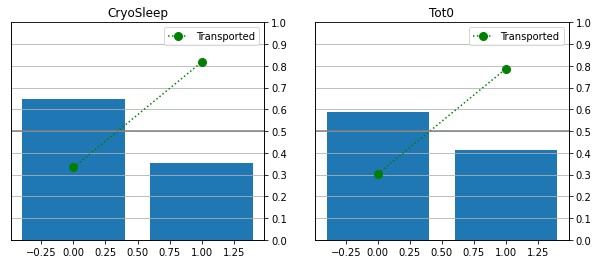

,count,Transported,Tot0
CryoSleep,,,
False,0.646988,0.332709,0.094525
True,0.353012,0.816895,1.000000


In [9]:
plot_bars  (df_trn, ['CryoSleep', 'Tot0'])
pd.DataFrame({'count':        df_trn.groupby('CryoSleep')['Transported'].count()/len(df_trn),
              'Transported':  df_trn.groupby('CryoSleep')['Transported'].mean(),
               'Tot0':  df_trn.groupby('CryoSleep')['Tot0'].mean()})


✅ Если человек не платил, то с достоверностю 0.85 был в гебернации (для восстановления пропусков)<br>


In [10]:
display( pd.DataFrame({'count': df_trn.groupby('Tot0')['CryoSleep'].count()/len(df_trn),
                       'Transported':  df_trn.groupby('Tot0')['Transported'].mean(),
                       'Cryo':  df_trn.groupby('Tot0')['CryoSleep'].mean()}) )

,count,Transported,Cryo
Tot0,,,
False,0.585831,0.303359,0.000000
True,0.414169,0.786915,0.852339


In [11]:
pd.DataFrame({'count':      df_trn.groupby('Age_0')['CryoSleep'].count(),
              'CryoSleep':  df_trn.groupby('Age_0')['CryoSleep'].mean()})

,count,CryoSleep
Age_0,,
False,6466,0.351376
True,140,0.428571


✅ При df.CryoSleep=df.Tot0 (if isna) в тренировочных данных 60% CryoSleep=F будут восстановлены верно. Остальные 40% с вероятностью 0.85.

In [12]:
df = pd.read_csv("dataset/train.csv")

df = df.loc[df.CryoSleep.isna()]
df['Tot']     = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck   
df['Tot0']    = df.Tot <= 0   
print(1-df.Tot0.mean())

0.599078341013825


## Planets

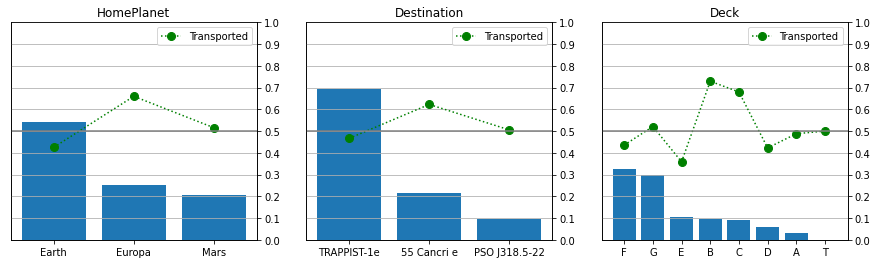

In [13]:
plot_bars(df_trn, ['HomePlanet','Destination', 'Deck'])

✅ Вероятность пропасть у `Europa`  выше, чем у `Earth`. Аналогично пропадают летящие на `55 Cancri e`<br>
✅ Европейцев селили на палубы `B, C` с которых пропасть вероятность была существенно выше. <br>
✅ Землян селили на "безопасные" палубы `G, F`.<br>

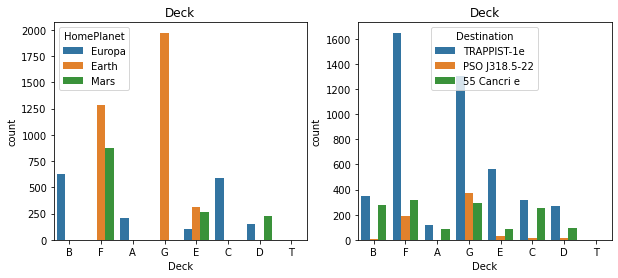

In [14]:
plot_counts(df_trn, ['Deck'], ['HomePlanet', 'Destination'])

✅ Большинство землян и марсиан летят на TRAPPIST-1e. На PSO летят в основном земляне.<br>

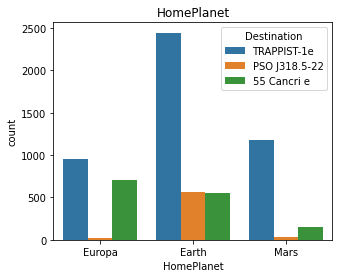

In [15]:
plot_counts(df_trn, ['HomePlanet'], ['Destination'])

✅ Обычно группа летит с одного места, но иногда на различные.<br>
✅ Жуткая история с Brighttt	 Philda	и Lyde - дети в разных кабинах на разные планеты.

In [16]:
df_trn.loc[df_trn.Size_GR > 1,  ['PassengerId','Size_GR','Cabin','CryoSleep', 'HomePlanet','Destination', 'Name2', 'Name1', 'Age', 'Transported']].head(20)
#df_trn[ ['PassengerId','Cabin','CryoSleep', 'HomePlanet','Destination', 'Name2', 'Name1', 'Age', 'Transported']].head(20)

,PassengerId,Size_GR,Cabin,CryoSleep,HomePlanet,Destination,Name2,Name1,Age,Transported
2,0003_01,2,A/0/S,False,Europa,TRAPPIST-1e,Susent,Altark,58.0,False
3,0003_02,2,A/0/S,False,Europa,TRAPPIST-1e,Susent,Solam,33.0,False
8,0008_01,2,B/1/P,True,Europa,55 Cancri e,Flatic,Erraiam,14.0,True
9,0008_03,2,B/1/P,False,Europa,55 Cancri e,Flatic,Wezena,45.0,True
15,0017_01,2,G/0/P,False,Earth,TRAPPIST-1e,Brighttt,Lyde,0.0,True
16,0017_02,2,F/6/P,False,Earth,55 Cancri e,Brighttt,Philda,14.0,False
17,0020_01,4,E/0/S,True,Earth,TRAPPIST-1e,Brantuarez,Almary,1.0,False
18,0020_02,4,E/0/S,True,Earth,55 Cancri e,Brantuarez,Glendy,49.0,False
19,0020_04,4,E/0/S,False,Earth,TRAPPIST-1e,Jacostanley,Breney,10.0,True
20,0020_06,4,E/0/S,False,Earth,TRAPPIST-1e,Mcfaddennon,Terta,7.0,False


## Age

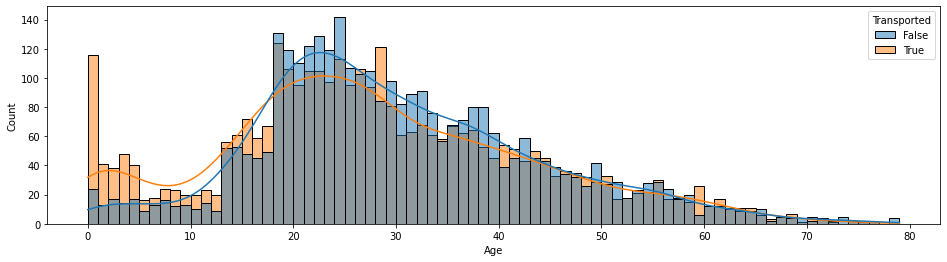

(0: 140 0.829) (1: 54 0.759) (2: 55 0.691) (3: 62 0.774) (4: 57 0.702) (5: 25 0.640) (6: 31 0.581) (7: 40 0.600) (8: 35 0.657) (9: 33 0.606) (10: 30 0.667) (11: 37 0.622) (12: 29 0.690) (13: 108 0.519) (14: 114 0.535) (15: 120 0.600) (16: 104 0.567) (17: 116 0.578) (18: 255 0.486) (19: 225 0.471) (20: 205 0.463) (21: 227 0.463) (22: 234 0.449) (23: 216 0.449) (24: 255 0.443) (25: 202 0.470) (26: 209 0.507) (27: 199 0.472) (28: 205 0.590) (29: 179 0.453) (30: 143 0.427) (31: 152 0.414) (32: 159 0.428) (33: 137 0.445) (34: 115 0.504) (35: 135 0.496) (36: 133 0.466) (37: 144 0.444) (38: 133 0.398) (39: 107 0.421) 

In [17]:
plt.figure(figsize=(16,4))
sns.histplot(data=df_trn, x='Age', hue='Transported', binwidth=1, kde=True); plt.show()

for a in range(40):
    age = df_trn.loc[df_trn.Age == a, 'Transported']
    print(f"({a}: {len(age)} {age.mean():.3f})", end=" ")

✅ Age: 0    - очень вероятно пропасть (0.829)<br>
✅ Age: 1-4  - (0.75)<br>
✅ Age: 5-12 - (0.65)<br>
✅ Age: 18-40 - (< 0.5)<br>
✅ Младенцев и молодёжь селили на палубе `G`<br>

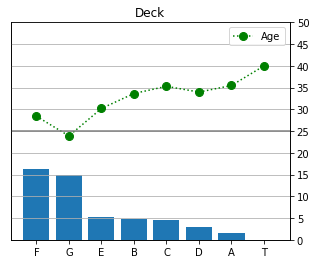

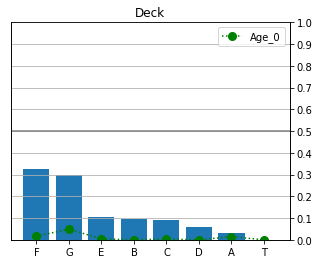

In [18]:
plot_bars(df_trn, ['Deck'], ['Age'], ylim=(0,50))
plot_bars(df_trn, ['Deck'], ['Age_0'])

## Группы
✅ Слабенький, но признак пропажи - одиночная 

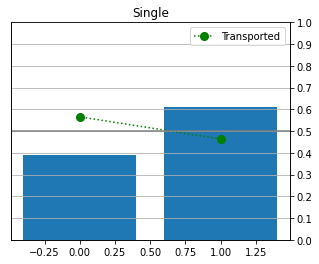

In [19]:
plot_bars(df_trn, ['Single'])

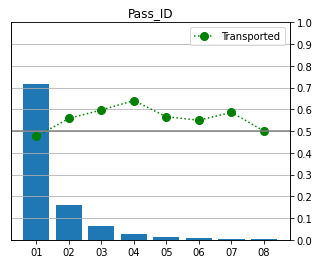

In [20]:
plot_bars(df_trn, ['Pass_ID'])

## Имена

In [21]:
names_trn = set(dict(df_trn.Name1.value_counts()).keys())
names_tst = set(dict(df_tst.Name1.value_counts()).keys())
print(len(names_trn), len(names_tst))
print(len(names_trn.intersection(names_tst)))

2531 1888
1640


In [22]:
df_trn['Name1_SFX'] = df_trn.Name1.map(lambda x: x[-2:])

res = dict(df_trn.Name1_SFX.value_counts())
tot, sfx = 0, set()
for i, k in enumerate(res):
    x = df_trn.loc[(df_trn.Name1_SFX == k) , 'Transported']  
    count, mean = x.count(), x.mean()
    if mean > 0.60 and count > 10:
        print(f"{k:12s}:{res[k]:3d} > count:{count:4d}, mean:{mean:.3f}")                
        sfx.add(k)
        tot += count
        
print(tot, sfx)  

on          :358 > count: 358, mean:0.631
ak          : 82 > count:  82, mean:0.659
ik          : 76 > count:  76, mean:0.711
ch          : 69 > count:  69, mean:0.609
ab          : 63 > count:  63, mean:0.651
am          : 58 > count:  58, mean:0.655
as          : 41 > count:  41, mean:0.780
ar          : 37 > count:  37, mean:0.676
ca          : 32 > count:  32, mean:0.625
id          : 31 > count:  31, mean:0.742
ib          : 28 > count:  28, mean:0.821
va          : 23 > count:  23, mean:0.652
ma          : 23 > count:  23, mean:0.652
ls          : 23 > count:  23, mean:0.652
tz          : 22 > count:  22, mean:0.818
ba          : 18 > count:  18, mean:0.667
ih          : 17 > count:  17, mean:0.706
ax          : 16 > count:  16, mean:0.688
fs          : 13 > count:  13, mean:0.692
bi          : 11 > count:  11, mean:0.636
eb          : 11 > count:  11, mean:0.727
1052 {'ib', 'ar', 'fs', 'ls', 'ab', 'ca', 'ba', 'va', 'ma', 'tz', 'ax', 'ch', 'am', 'ih', 'bi', 'eb', 'as', 'on', 'ak'

male 

count        6606
unique          6
top       unknown
freq         5483
Name: Sex, dtype: object 

unknown          5483
female            644
male              335
mostly_male        67
andy               57
mostly_female      20
Name: Sex, dtype: int64


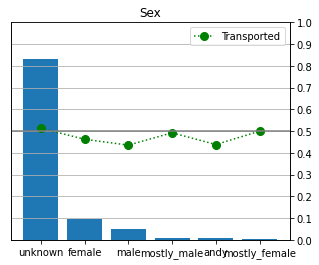

In [23]:
#!pip install -q gender_guesser

import gender_guesser.detector as gender
gd = gender.Detector()
print(gd.get_gender(u"Bob"), "\n")

df_trn['Sex'] = df_trn.Name1.apply(lambda x: gd.get_gender(x) )

print(df_trn.Sex.describe(), "\n")
print(df_trn.Sex.value_counts())

plot_bars(df_trn, ['Sex'])

## Траты

✅  Сильная дисперсия в финансах (от 0 до 30k)<br>

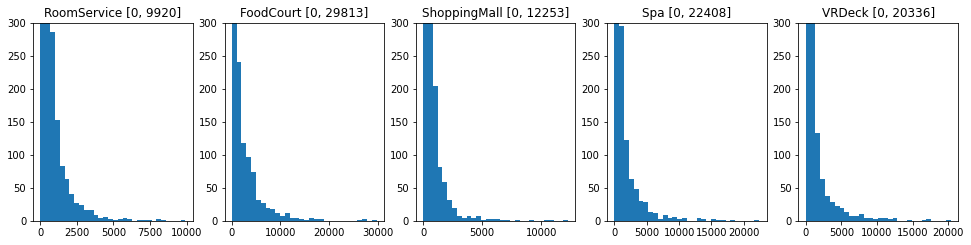

In [24]:
plot_float(df_trn, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], ymax=300)

## Cabins

✅  6561 кают `Cabin` на 8693 человек (**1.3** человека на каюту)<br>

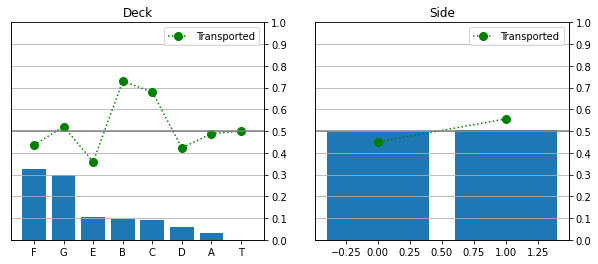

In [25]:
plot_bars(df_trn, ['Deck', 'Side'])

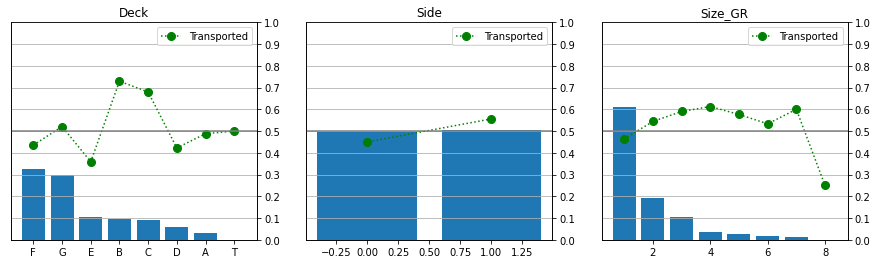

Tot0                     > count:2736,   mean:0.787
CryoSleep==T             > count:2332,   mean:0.817
CryoSleep==F             > count:4274,   mean:0.333

CryoSleep==T, Deck_BCD   > count: 649,   mean:0.992
CryoSleep==T, Deck_ABCDF > count:1125,   mean:0.988
CryoSleep==F, Deck_DET   > count: 848,   mean:0.284

CryoSleep==T, Deck_B     > count: 334,   mean:0.994,       351
CryoSleep==T, Deck_C     > count: 239,   mean:0.992,       339
CryoSleep==T, Deck_D     > count:  76,   mean:0.987,       295
CryoSleep==T, Deck_F     > count: 423,   mean:0.986,      1894
CryoSleep==T, Deck_A     > count:  53,   mean:0.943,       107
CryoSleep==T, Deck_G     > count:1072,   mean:0.659,      1507
CryoSleep==T, Deck_E     > count: 135,   mean:0.652,       608
CryoSleep==T, Deck_T     > count:   0,   mean:nan,         3
Tot0==T                  > count: 370,   Cryo:0.903
Tot0==T                  > count: 252,   Cryo:0.948
Tot0==T                  > count:  78,   Cryo:0.974
Tot0==T                  > c

In [26]:
plot_bars(df_trn,['Deck', 'Side', 'Size_GR'])

x = df_trn.loc[(df_trn.Tot0), 'Transported']
print(f"Tot0                     > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep), 'Transported']
print(f"CryoSleep==T             > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep == False), 'Transported']
print(f"CryoSleep==F             > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep) & (df_trn.Deck_BCD), 'Transported']
print(f"\nCryoSleep==T, Deck_BCD   > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep) & (df_trn.Deck_ABCDF), 'Transported']
print(f"CryoSleep==T, Deck_ABCDF > count:{x.count():4d},   mean:{x.mean():.3f}")

x = df_trn.loc[(df_trn.CryoSleep  == False) & (df_trn.Deck_DET), 'Transported']
print(f"CryoSleep==F, Deck_DET   > count:{x.count():4d},   mean:{x.mean():.3f}\n")

for d in 'BCDFAGET':
    number = df_trn.loc[df_trn.Deck == d].Number.astype(int)
    x = df_trn.loc[(df_trn.CryoSleep ) & (df_trn.Deck == d) , 'Transported']  
    print(f"CryoSleep==T, Deck_{d}     > count:{x.count():4d},   mean:{x.mean():.3f},    {number.max():6.0f}")    
    
for d in 'BCDFAGET':    
    x = df_trn.loc[(df_trn.Tot0 == True) & (df_trn.Deck == d), 'CryoSleep']
    print(f"Tot0==T                  > count:{x.count():4d},   Cryo:{x.mean():.3f}")    

In [27]:
df = pd.read_csv("dataset/train.csv")
df = df.loc[df.Cabin.isna()]
df['Tot']     = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck   
df['Tot0']    = df.Tot <= 0   
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Tot,Tot0
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False,908.0,False
93,0101_01,Mars,True,NaN,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Book Trad,True,0.0,True
103,0110_01,Europa,False,NaN,TRAPPIST-1e,32.0,False,0.0,410.0,6.0,3929.0,764.0,Graviph Aloubtled,False,5109.0,False
222,0239_01,Mars,False,NaN,TRAPPIST-1e,37.0,False,637.0,0.0,0.0,92.0,319.0,Diedow Resty,False,1048.0,False
227,0244_01,Mars,True,NaN,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,Froos Sad,True,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8209,8772_02,Europa,False,NaN,55 Cancri e,53.0,False,0.0,1127.0,0.0,3939.0,NaN,Naosura Motled,False,NaN,False
8475,9057_01,Europa,False,NaN,55 Cancri e,36.0,True,132.0,3479.0,0.0,3786.0,0.0,Coxan Statch,False,7397.0,False
8485,9069_03,Europa,True,NaN,55 Cancri e,25.0,False,0.0,0.0,0.0,0.0,0.0,Bath Brakeng,True,0.0,True
8509,9081_03,Earth,True,NaN,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,0.0,0.0,Beula Clemondsey,False,0.0,True


## Геометрия корабля

Deck: ABCDEFGT
Side: [False, True]


<AxesSubplot:xlabel='Number', ylabel='Count'>

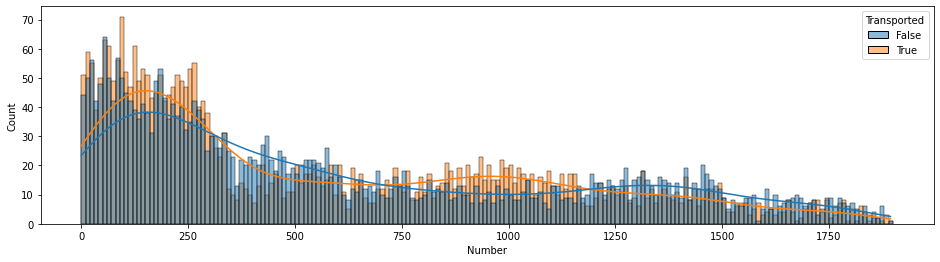

In [28]:
print("Deck:", "".join(sorted(df_trn.Deck.unique())))
print("Side:",  sorted(df_trn.Side.unique()) )

plt.figure(figsize=(16,4))
sns.histplot(data=df_trn, x='Number', hue='Transported', binwidth=10, kde=True)


✅  Выглядит, как зависимость пропаж от номера. Но на самомо деле её нет (кроме палубы G [760-1160] и F?):

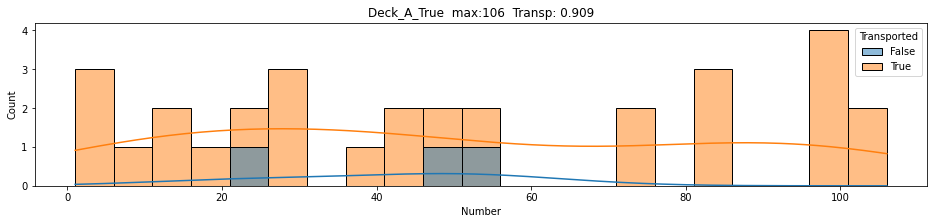

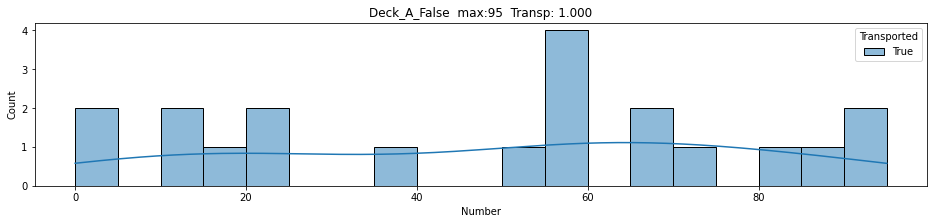

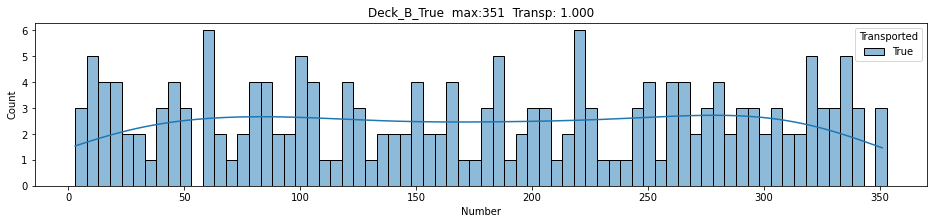

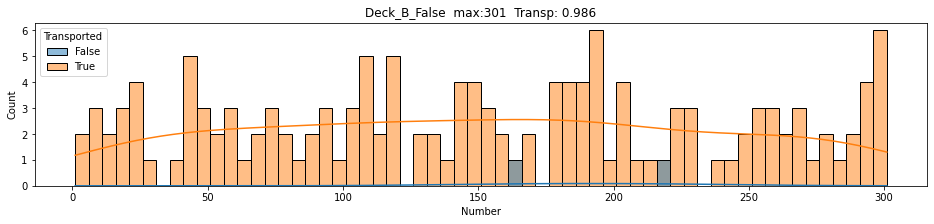

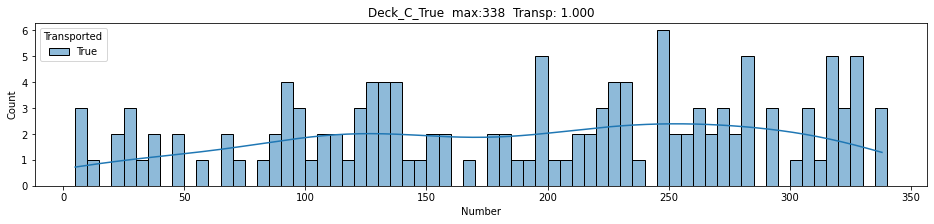

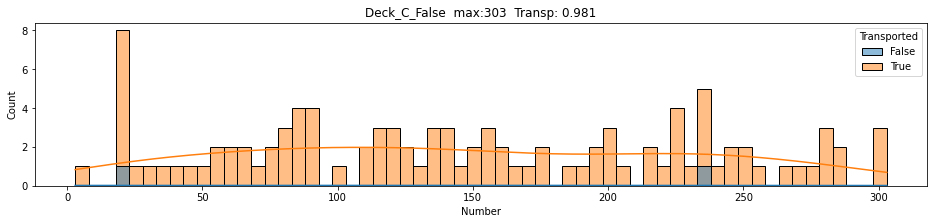

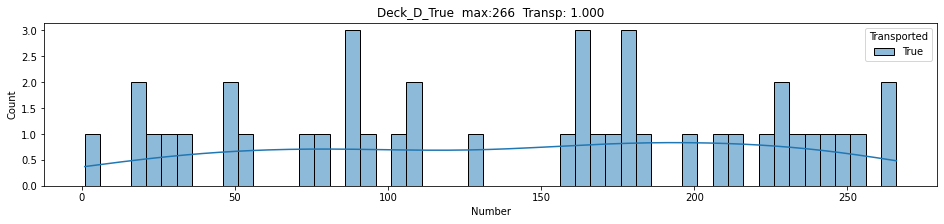

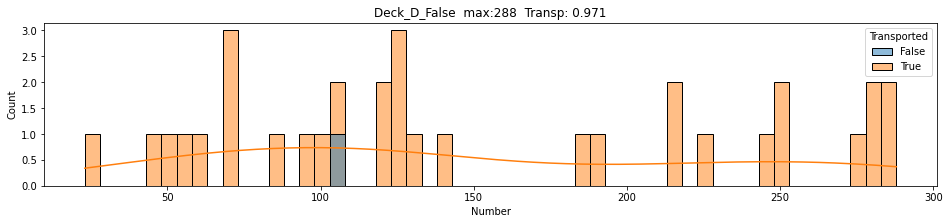

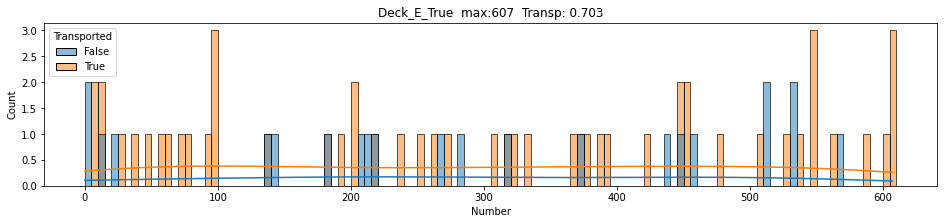

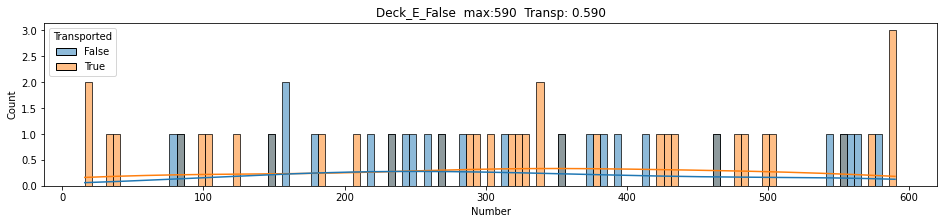

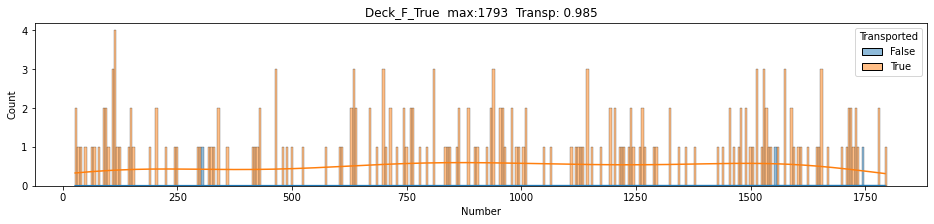

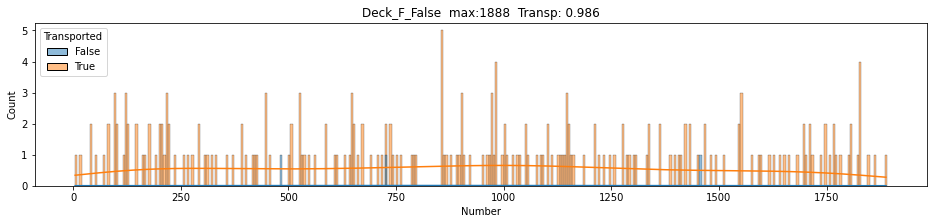

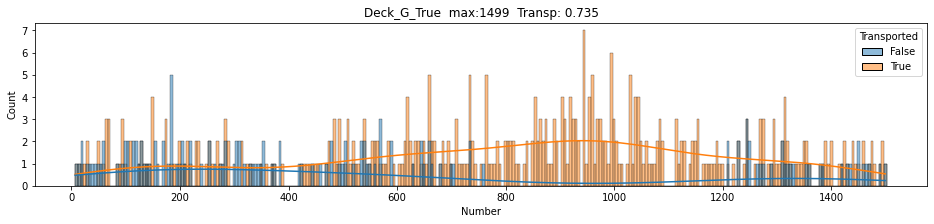

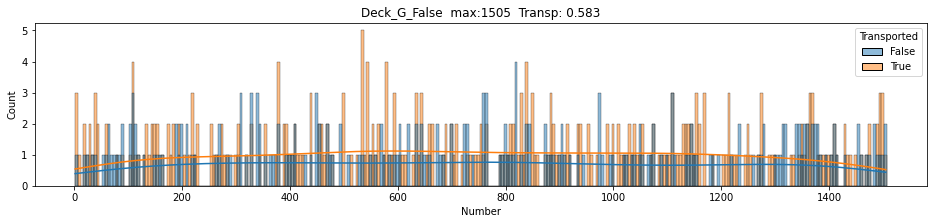

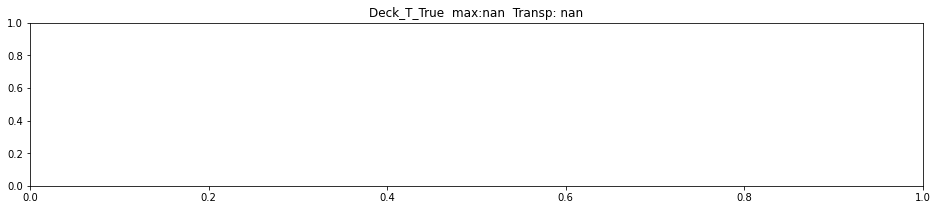

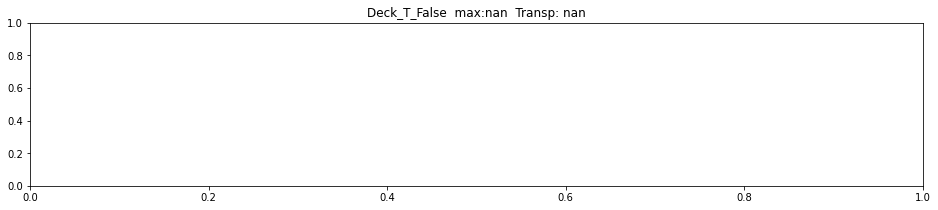

In [29]:
for d in 'ABCDEFGT':
    for side in [True, False]:
        plt.figure(figsize=(16,3))
        df = df_trn[(df_trn.Deck==d) & (df_trn.CryoSleep) & (df_trn.Side == side)]  
        sns.histplot(data=df, x='Number', hue='Transported', binwidth=5, kde=True)
        plt.title(f"Deck_{d}_{side}  max:{df.Number.max()}  Transp: {df.Transported.mean():.3f}")        
        plt.show()
   

```       
       max Number     CryoSleep        ~CryoSleep         по больнице 0.827 / 0.333
Deck    S      P        S       P        S       P
A     107     98    0.909   1.000    0.378   0.278
B     351    301    1.000   0.986    0.503   0.348
C     339    309    1.000   0.981    0.597   0.306
D     276    295    1.000   0.971    0.287   0.273
E     608    595    0.703   0.590    0.287   0.286
F    1793   1894    0.985   0.986    0.344   0.269
G    1500   1507    0.735   0.583    0.424   0.291        (на G/.../S в основном пропали в 600-1200)
T       0      3    только 2 номера T/1/P, T/3/P
```
✅  Выкинуть из onehot палубу T<br>
✅  Добавить признак G/750-1200/S (вместе с CryoSleep 0.994, 166 чел)

In [35]:
df = df_trn[(df_trn.Deck=='G') & (df_trn.Number >= 750) & (df_trn.Number <= 1200) & (df_trn.Side) & (df_trn.CryoSleep)]
print(df.Transported.mean(), df.Transported.count())
print(df_trn[df_trn.CryoSleep].Transported.mean())

df_trn[(df_trn.Deck=='T') ]

0.9939759036144579 166
0.8168953687821612


,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,...,Name2,Tot,Tot0,Age_0,Age_1_4,Age_5_12,Age_18_40,Name1_SFX,Sex,GNS
1680,2254,2414_01,Europa,False,T/1/P,TRAPPIST-1e,42.0,False,0.0,1829.0,...,Headfair,7411.0,False,False,False,False,False,ak,unknown,False
2061,2763,2971_01,Europa,False,T/3/P,TRAPPIST-1e,38.0,False,0.0,3135.0,...,Sessiouse,3164.0,False,False,False,False,True,nt,unknown,False


## Simple Model

In [31]:
df = df_trn
N = len(df)
df['GNS'] = (df.Deck == 'G') & (df.Number >= 750) & (df.Number <= 1200) & (df.Side == True)
print(df.GNS.mean())

def stat(df,  info=""):
    print(f"{df.Transported.mean():.3f}  {df.Transported.count()/N:.3f}  {info}")

stat(df[df.CryoSleep], "CryoSleep")
stat(df[(df.CryoSleep) & (df.Deck.isin(['A','B','C','D','F']) |  (df.GNS))  ], "CryoSleep & ABCDF")
stat(df[(df.CryoSleep) & ~(df.Deck.isin(['A','B','C','D','F']) |  (df.GNS))  ], "CryoSleep & ~ABCDF")

display(df.GNS)

0.04511050560096882
0.817  0.353  CryoSleep
0.988  0.195  CryoSleep & ABCDF
0.604  0.158  CryoSleep & ~ABCDF


0       False
1       False
2       False
3       False
4       False
        ...  
6601    False
6602    False
6603    False
6604    False
6605    False
Name: GNS, Length: 6606, dtype: bool

## Test and Train 

✅ Кабины и группы пассажиров в trn и tst не пересекаются, т.е. выборка tst не вполне случайна <br>

In [32]:
cabin_trn = set(dict(df_trn.Cabin.value_counts()).keys() )
cabin_tst = set(dict(df_tst.Cabin.value_counts()).keys() )
cabin_trn.intersection(cabin_tst)

set()

In [33]:
gr_trn = set(dict(df_trn.Pass_GR.value_counts()).keys() )
gr_tst = set(dict(df_tst.Pass_GR.value_counts()).keys() )
gr_trn.intersection(gr_tst)

set()

In [34]:
deck_trn = set(dict(df_trn.Deck.value_counts()).keys() )
deck_tst = set(dict(df_tst.Deck.value_counts()).keys() )
deck_trn.intersection(deck_tst)

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'}

In [32]:
# Средние значения bool признаков для тестовых и тренировочных данных:
for col in df_tst:                          
    if df_tst[col].dtype == bool:        
        m_tst, m_trn =   df_tst[col].mean(), df_trn[col].mean(),
        print(f"{m_tst:.2f}   {m_trn:.2f}  {m_tst-m_trn:5.2f}  {col}")

0.37   0.35   0.02  CryoSleep
0.02   0.02  -0.01  VIP
0.61   0.61  -0.00  Single
0.50   0.51  -0.01  Side
0.23   0.24  -0.01  Deck_BCD
0.61   0.60   0.01  Deck_BCDFA
0.17   0.16   0.01  Deck_DET
0.42   0.41   0.01  Tot0
0.02   0.02  -0.00  Age_0
0.03   0.03  -0.01  Age_1_4
0.04   0.04  -0.00  Age_5_12
0.63   0.61   0.01  Age_18_40


# Conclusion

Блок который будем использовать при машинном обучении

In [33]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

#-------------------------------------------------------------------------------------    

def add_features_from_PassengerId(df):
    """ 
    Разбиваем id-пасажира на номер группы и положение в группе, добавляем численность группы.
    Этот признак не имеет пропусков (как и Transported).
    """
    
    df['Pass_GR'] = df.PassengerId.map(lambda x: x.split('_')[0])  # GR_ID
    df['Pass_ID'] = df.PassengerId.map(lambda x: x.split('_')[1])

    groups = df.Pass_GR.value_counts()                            # число людей в данной группе    
    df['Size_GR'] = df['Pass_GR'].map(lambda x: groups[x])        # для каждого человека резмер его группы
    
    df['Single']  = df.Size_GR == 1                               # летел один
    df.Size_GR    = df.Size_GR.astype(float)
    
    return df

#-------------------------------------------------------------------------------------    

def fill_gaps_in_float(df):
    """ Заполняем пропуски в вещественных данных: Age, Spents """
    
    for col in df:                        
        if df[col].dtype == float:  
            if col == "Age":
                df.loc[df[col].isna(), col] = df[col].median()  # самый типичный возраст
            else:
                df.loc[df[col].isna(), col] = 0                 # не знаем - не тратил :)
                
    # Суммарные траты и логический признак отсутствия трат
    df['Tot']   = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck   
    df['Tot0']  = df.Tot <= 0   
    
    # из линейной модели следует, что эти пары трат оказывают противополжное влияние 
    df['Spa_VR']        = df.Spa + df.VRDeck                  
    df['Food_Shooping'] = df.FoodCourt + df.ShoppingMall
    
    return df

#-------------------------------------------------------------------------------------    

def fill_gaps_in_CryoSleep_VIP(df):
    """ Заполняем пропуски в CryoSleep, VIP """
    
    gaps = df.CryoSleep.isna()                                     # все записи с неизвестной гибернацией
    df.loc[gaps, 'CryoSleep'] = df.loc[gaps, 'Tot0']               # не тратил - видимо спал
    df.CryoSleep = df.CryoSleep.astype(bool)
        
    gaps = df.VIP.isna()
    df.loc[gaps, 'VIP'] = df.loc[gaps, 'Tot'] >= 10000             # немного надумано, но VIP-пов мало,     
    df.VIP = df.VIP.astype(bool)
    return df    
        
#-------------------------------------------------------------------------------------    

def fill_gaps_from_group(df, col):
    """ Заполняем пропуски в колонке col по значениям из данной группы"""
    
    indx = df[df[col].isna()].index
    for i in indx:
        ID = df.iloc[i].Pass_GR
        for k in range(1, 6):
            if i-k >=0 and df.iloc[i-k].Pass_GR == ID:
                df.iloc[i, df.columns.get_loc(col)] = df.iloc[i-k, df.columns.get_loc(col)]
                break            
            elif i+k < len(df) and df.iloc[i+k].Pass_GR == ID:
                df.iloc[i, df.columns.get_loc(col)] = df.iloc[i+k, df.columns.get_loc(col)]
                break         
    return df

#-------------------------------------------------------------------------------------    

def fill_gaps_in_objects(df):
    """ Заменяем оставшиеся NaN на ? """
    
    for col in df:
        if df[col].dtype == object:  
            if col == "Cabin":
                df.loc[df[col].isna(), col] = "?/-1/?"         
            elif col == "Name":
                df.loc[df[col].isna(), col] = "? ?"                         
            else:
                df.loc[df[col].isna(), col] = "?"         
            
            #df.loc[df[col].isna(), col] = df[col].mode()[0]        # for categorical - most frequent value  - not good idea            
            #if col not in ["GAPS","Transported"]:   df[col] = df[col].astype(str)                  
    return df                

#-------------------------------------------------------------------------------------        

def amounts_mean(df, lst = ["Tot", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", 'Spa_VR', 'Food_Shooping']):   
    """
    Одна группа могла записывать траты деньги на одного члена (например, главу), но ходить все, кто не в капсуле
    """
    
    for ls in lst:
        df[ls + "_MEAN"] = 0

    ids = dict(df.Pass_ID.value_counts())
    for ID, NUM in ids.items():            
        if NUM == 1:
            break            
            
        for ls in lst:            
            dd = df.loc[(df.Pass_ID == ID) & (df.CryoSleep == False), ls]
            df.loc[dd.index, ls+'_MEAN'] = dd.mean()   
            
    return df    
    
#-------------------------------------------------------------------------------------        

def add_features2(df):
    """ Остальные фичи """

    for col in  ['RoomService', 'FoodCourt',  'ShoppingMall', 'Spa', 'VRDeck', 'Spa_VR', 'Food_Shooping']:
        df[col+"1"] = df[col] > 1000                  # активно тратили (? порог)
        share = col+"_SHARE"
        df[share] = df[col] / df['Tot']               # доля от общих трат
        df.loc[df[share].isna(), share] = 0           # было деление на 0    
        
    df['Age_0']     = df.Age <= 0
    df['Age_1_4']   = df.Age <= 0
    df['Age_1_4']   = (df.Age >=  1) & (df.Age <=  4)
    df['Age_5_12']  = (df.Age >=  5) & (df.Age <= 12)
    df['Age_18_40'] = (df.Age >= 18) & (df.Age <= 40)        

    df['Deck']      = df.Cabin.map(lambda x: x.split('/')[0])
    df['Number']    = df.Cabin.map(lambda x: x.split('/')[1]).astype(float)
    df['Side']      = df.Cabin.map(lambda x: x.split('/')[2])    

    df['Deck_BCD']   = df.Deck.map(lambda x: x in 'BCD' )         # группировка по каютам 
    df['Deck_DET']   = df.Deck.map(lambda x: x in 'DET' )    
    df['Deck_ABCDF'] = df.Deck.map(lambda x: x in 'ABCDF' )        
    df['Deck_GNS']   = (df.Deck == 'G') & (df.Number >= 750) & (df.Number <= 1200) & (df.Side == True)
    
    
    df['Numbers_G1'] = (df.Deck == 'G') &  ((df.Number >=760) & (df.Number <= 1160))
    df['Numbers_G2'] = (df.Deck == 'G') &  ((df.Number < 760) | (df.Number >  1160))    
    
    df['CryoSleep_Deck_ABCDF'] = (df.CryoSleep  == True)  & (df.Deck_ABCDF)     
    df['~CryoSleep_Deck_DET']  = (df.CryoSleep  == False) & (df.Deck_DET)     
    
    df['Name1']     = df.Name.map(lambda x: x.split(' ')[0])
    df['Name2']     = df.Name.map(lambda x: x.split(' ')[1])
       
    df.CryoSleep    = df.CryoSleep.astype(bool)
    df.VIP          = df.VIP.astype(bool)
    df.Side         = df.Side == 'S'                 # {S,P}
    return df

#-------------------------------------------------------------------------------------    

def normalize(df):  
    """ Норализуем данные (для моделей с расстояниями это важно) """
    
    for col in  ['RoomService', 'FoodCourt',  'ShoppingMall', 'Spa', 'VRDeck', 'Spa_VR', 'Food_Shooping']:
        df[col] = np.tanh( df[col]/2000 )    # ближе к 1 
        
    df.Tot = np.tanh( df.Tot/2000 )        
    df.Age      /= 80
    df.Number   /= 2000
    
    return df
#-------------------------------------------------------------------------------------    

def vectorize(df):
    """ 
    One-hot кодирование категориальных признаков.
    Если значение не в спсиске, все колонки признаков будут равны нулю
    """
    
    for col in ['Earth', 'Europa', 'Mars']:
        df[col] = df.HomePlanet == col
        
    for col in ['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22']:        
        df[col] = df.Destination == col        
        
    for col in "BCDFAGET":
        df[col] = df.Deck == col                
        
    return df  
#-------------------------------------------------------------------------------------    

def prepare_data(df):
    df = add_features_from_PassengerId(df)
    
    df = fill_gaps_in_float(df)
    df = fill_gaps_in_CryoSleep_VIP(df)
    df = fill_gaps_from_group(df, 'Cabin')
    df = fill_gaps_from_group(df, 'HomePlanet')
    df = fill_gaps_from_group(df, 'Destination')  # не очень надёжно    
    df = fill_gaps_in_objects(df)        
    
    df = add_features2(df)
    df = amounts_mean(df)

    df = normalize(df)
    df = vectorize(df)
    
    return df        

#-------------------------------------------------------------------------------------    

def shuffle_data(X,Y):
    idx = np.random.permutation(len(Y)) 
    return X[idx], Y[idx]        
    
#---------------------------------------------------------------------------------------

def eval_model(clf, X,Y, count=1, cv=100, prob = True, mix=True, info=""):
    count = max(1, count)
    cv    = max(2, cv)
    if mix:
        X, Y = shuffle_data(X,Y)
        
    acc_tst, acc_trn, recall_tst, recall_trn = np.array([]),  np.array([]),   np.array([]),  np.array([])
    tm1 = time.process_time() 
    for _ in range(count):
        res = cross_validate(clf, X, Y, cv=cv, return_train_score=True, scoring=['accuracy', 'recall'])                
        acc_tst     = np.concatenate([acc_tst,    res['test_accuracy']])
        acc_trn     = np.concatenate([acc_trn,    res['train_accuracy']])
        recall_tst  = np.concatenate([recall_tst, res['test_recall']])
        recall_trn  = np.concatenate([recall_trn, res['train_recall']])          
    tm2 = time.process_time()     
    
    clf.fit(X,Y)
    probs = clf.predict_proba(X)  if prob else [[0, 0]]
    probs = np.max(probs, axis=1)
    
    print(f"val: {acc_tst.mean():.3f} [{acc_tst.min():.3f}-{acc_tst.max():.3f}] recall:{recall_tst.mean():.3f};   trn: {acc_trn.mean():.3f} [{acc_trn.min():.3f}-{acc_trn.max():.3f}] recall:{recall_trn.mean():.3f}   probs: {probs.mean():.3f}  {(tm2-tm1)/len(acc_tst):.2f}s   {info}")
    #print(f"val: {acc_tst.mean():.3f} ± {acc_tst.std()/len(acc_tst)**0.5:.3f} [{acc_tst.min():.3f}-{acc_tst.max():.3f}] recall:{recall_tst.mean():.3f};   trn: {acc_trn.mean():.3f} ± {acc_trn.std()/len(acc_trn)**0.5:.3f}  [{acc_trn.min():.3f}-{acc_trn.max():.3f}] recall:{recall_trn.mean():.3f}   probs: {probs.mean():.3f} ± {probs.std():.3f}    {(tm2-tm1)/len(acc_tst):.2f}s   {info}")
    return acc_tst.mean(),  acc_trn.mean(), probs.mean()

#---------------------------------------------------------------------------------------

def confusion(clf, X_true, Y_true):    
    Y_pred = clf.predict(X_true)
    cm1 = confusion_matrix(Y_true, Y_pred)
    cm2 = confusion_matrix(Y_true, Y_pred, normalize='true')
    plt.figure(figsize = (5,2), facecolor="w")
    plt.subplot(1, 2, 1) 
    N1, N2 = cm1[0,0]+cm1[0,1], cm1[1,0]+cm1[1,1]
    plt.title(f" W: ({N1/(N1+N2):.2f},{N2/(N1+N2):.2f})")
    sn.heatmap(cm1, annot=True, cbar=False, annot_kws={"size": 16}, fmt="d")
    plt.subplot(1, 2, 2)     
    plt.title(f"acc: {(cm1[0,0]+cm1[1,1])/cm1.sum():.3f}")
    sn.heatmap(cm2, annot=True, cbar=False, annot_kws={"size": 16}, fmt=".3f")    
    plt.show()
    return cm1

In [34]:
df_trn = pd.read_csv("dataset/train.csv")
df_tst = pd.read_csv("dataset/test.csv")     

df_trn = prepare_data(df_trn)
df_tst = prepare_data(df_tst)

#display(df_trn.info())
#display(df_tst.info())
#display(df_trn.describe(include=[bool]))

print("total features:", len(df_trn.columns))
columns = list(df_trn.columns)
print([col for col in columns if df_trn[col].dtype==bool and col != 'Transported'])
print([col for col in columns if df_trn[col].dtype==float])

total features: 74
['CryoSleep', 'VIP', 'Single', 'Tot0', 'RoomService1', 'FoodCourt1', 'ShoppingMall1', 'Spa1', 'VRDeck1', 'Spa_VR1', 'Food_Shooping1', 'Age_0', 'Age_1_4', 'Age_5_12', 'Age_18_40', 'Side', 'Deck_BCD', 'Deck_BCDFA', 'Deck_DET', 'Numbers_G1', 'Numbers_G2', 'CryoSleep_Deck_BCDFA', '~CryoSleep_Deck_DET', 'Earth', 'Europa', 'Mars', 'TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22', 'B', 'C', 'D', 'F', 'A', 'G', 'E', 'T']
['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Size_GR', 'Tot', 'Spa_VR', 'Food_Shooping', 'RoomService_SHARE', 'FoodCourt_SHARE', 'ShoppingMall_SHARE', 'Spa_SHARE', 'VRDeck_SHARE', 'Spa_VR_SHARE', 'Food_Shooping_SHARE', 'Number', 'Tot_MEAN', 'RoomService_MEAN', 'FoodCourt_MEAN', 'ShoppingMall_MEAN', 'Spa_MEAN', 'VRDeck_MEAN', 'Spa_VR_MEAN', 'Food_Shooping_MEAN']


In [35]:
FEATURE_KIND = 'all'

if   FEATURE_KIND == 'base':
    COLUMNS = ['CryoSleep', 'VIP', 'Side', 'Earth', 'Europa', 'Mars', 'TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22', 
               'B', 'C', 'D', 'F', 'A', 'G', 'E', 'T'] + ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Number']
        
elif   FEATURE_KIND == 'bool':        
    COLUMNS =  ['CryoSleep', 'VIP', 'Single', 'Tot0', 'RoomService1', 'FoodCourt1', 'ShoppingMall1', 'Spa1', 'VRDeck1', 'Age_0', 'Age_1_4', 'Age_5_12', 'Age_18_40', 'Side', 'Deck_BCD', 'Deck_BCDFA', 'Deck_DET', 'Numbers_G1', 'Numbers_G2', 'CryoSleep_Deck_BCDFA', '~CryoSleep_Deck_DET', 'Earth', 'Europa', 'Mars', 'TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22', 'B', 'C', 'D', 'F', 'A', 'G', 'E', 'T']               

elif FEATURE_KIND == 'all':
    
    COLUMNS = ['CryoSleep', 'VIP', 'Single', 'Tot0', 'RoomService1', 'FoodCourt1', 'ShoppingMall1', 'Spa1', 'VRDeck1', 'Age_0', 'Age_1_4', 'Age_5_12', 'Age_18_40', 'Side', 'Deck_BCD', 'Deck_BCDFA', 'Deck_DET', 'Numbers_G1', 'Numbers_G2', 'CryoSleep_Deck_BCDFA', '~CryoSleep_Deck_DET',
               'Earth', 'Europa', 'Mars', 'TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22', 'B', 'C', 'D', 'F', 'A', 'G', 'E', 'T'] + ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Size_GR', 'Tot', 'RoomService_SHARE', 'FoodCourt_SHARE', 'ShoppingMall_SHARE', 'Spa_SHARE', 'VRDeck_SHARE', 'Number']
else:
    COLUMNS = []
    
X   = df_trn[COLUMNS].to_numpy()  # .astype(np.float32) 
Y   = df_trn.Transported.to_numpy().astype(np.int64) 
X,Y = shuffle_data(X,Y)

X_tst = df_tst[COLUMNS].to_numpy()

print(X.shape)
display(df_trn[COLUMNS].head(3))
#display(df_trn[COLUMNS].info())


(8693, 49)


,CryoSleep,VIP,Single,Tot0,RoomService1,FoodCourt1,ShoppingMall1,Spa1,VRDeck1,Age_0,...,Spa,VRDeck,Size_GR,Tot,RoomService_SHARE,FoodCourt_SHARE,ShoppingMall_SHARE,Spa_SHARE,VRDeck_SHARE,Number
0,False,False,True,True,False,False,False,False,False,False,...,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,False,False,True,False,False,False,False,False,False,False,...,0.267807,0.021996,1.0,0.352241,0.148098,0.012228,0.033967,0.745924,0.059783,0.0
2,False,True,False,False,False,True,False,True,False,False,...,0.997578,0.024495,2.0,0.999938,0.004141,0.344409,0.000000,0.646730,0.004719,0.0
